In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl
import torch
from pypalettes import get_hex
#pip install git+https://github.com/KindXiaoming/pykan.git
import sys
sys.path.append(r"C:\Users\TESTER\OneDrive\Documentos\GitHub\Projects_Zone")

import utils as u

In [2]:
test_data = pd.read_csv(r"Datasets/UNSW_NB15 Dataset/Training and Testing Sets/UNSW_NB15_testing-set.csv")
train_data = pd.read_csv(r"Datasets/UNSW_NB15 Dataset/Training and Testing Sets/UNSW_NB15_training-set.csv")

In [3]:
len(train_data["proto"].unique()), len(test_data["proto"].unique())

(133, 131)

In [4]:
columns_numeric = train_data.select_dtypes(include="number").drop(columns="id").columns

In [5]:
len(columns_numeric)

40

In [6]:
columns_numeric = [
    col for col in columns_numeric
    if not len(train_data[col].value_counts()) < 3
]

In [7]:
len(columns_numeric)

38

In [8]:
train_data.set_index("id", inplace=True)

In [9]:
test_data.set_index("id", inplace=True)

In [10]:
pd.set_option('display.max_columns', 120)
train_data.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.2956,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.0,0.0,0.0,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.9150,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.0,0.0,0.0,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0


# Data Preprocessing

## Outlier Treatment

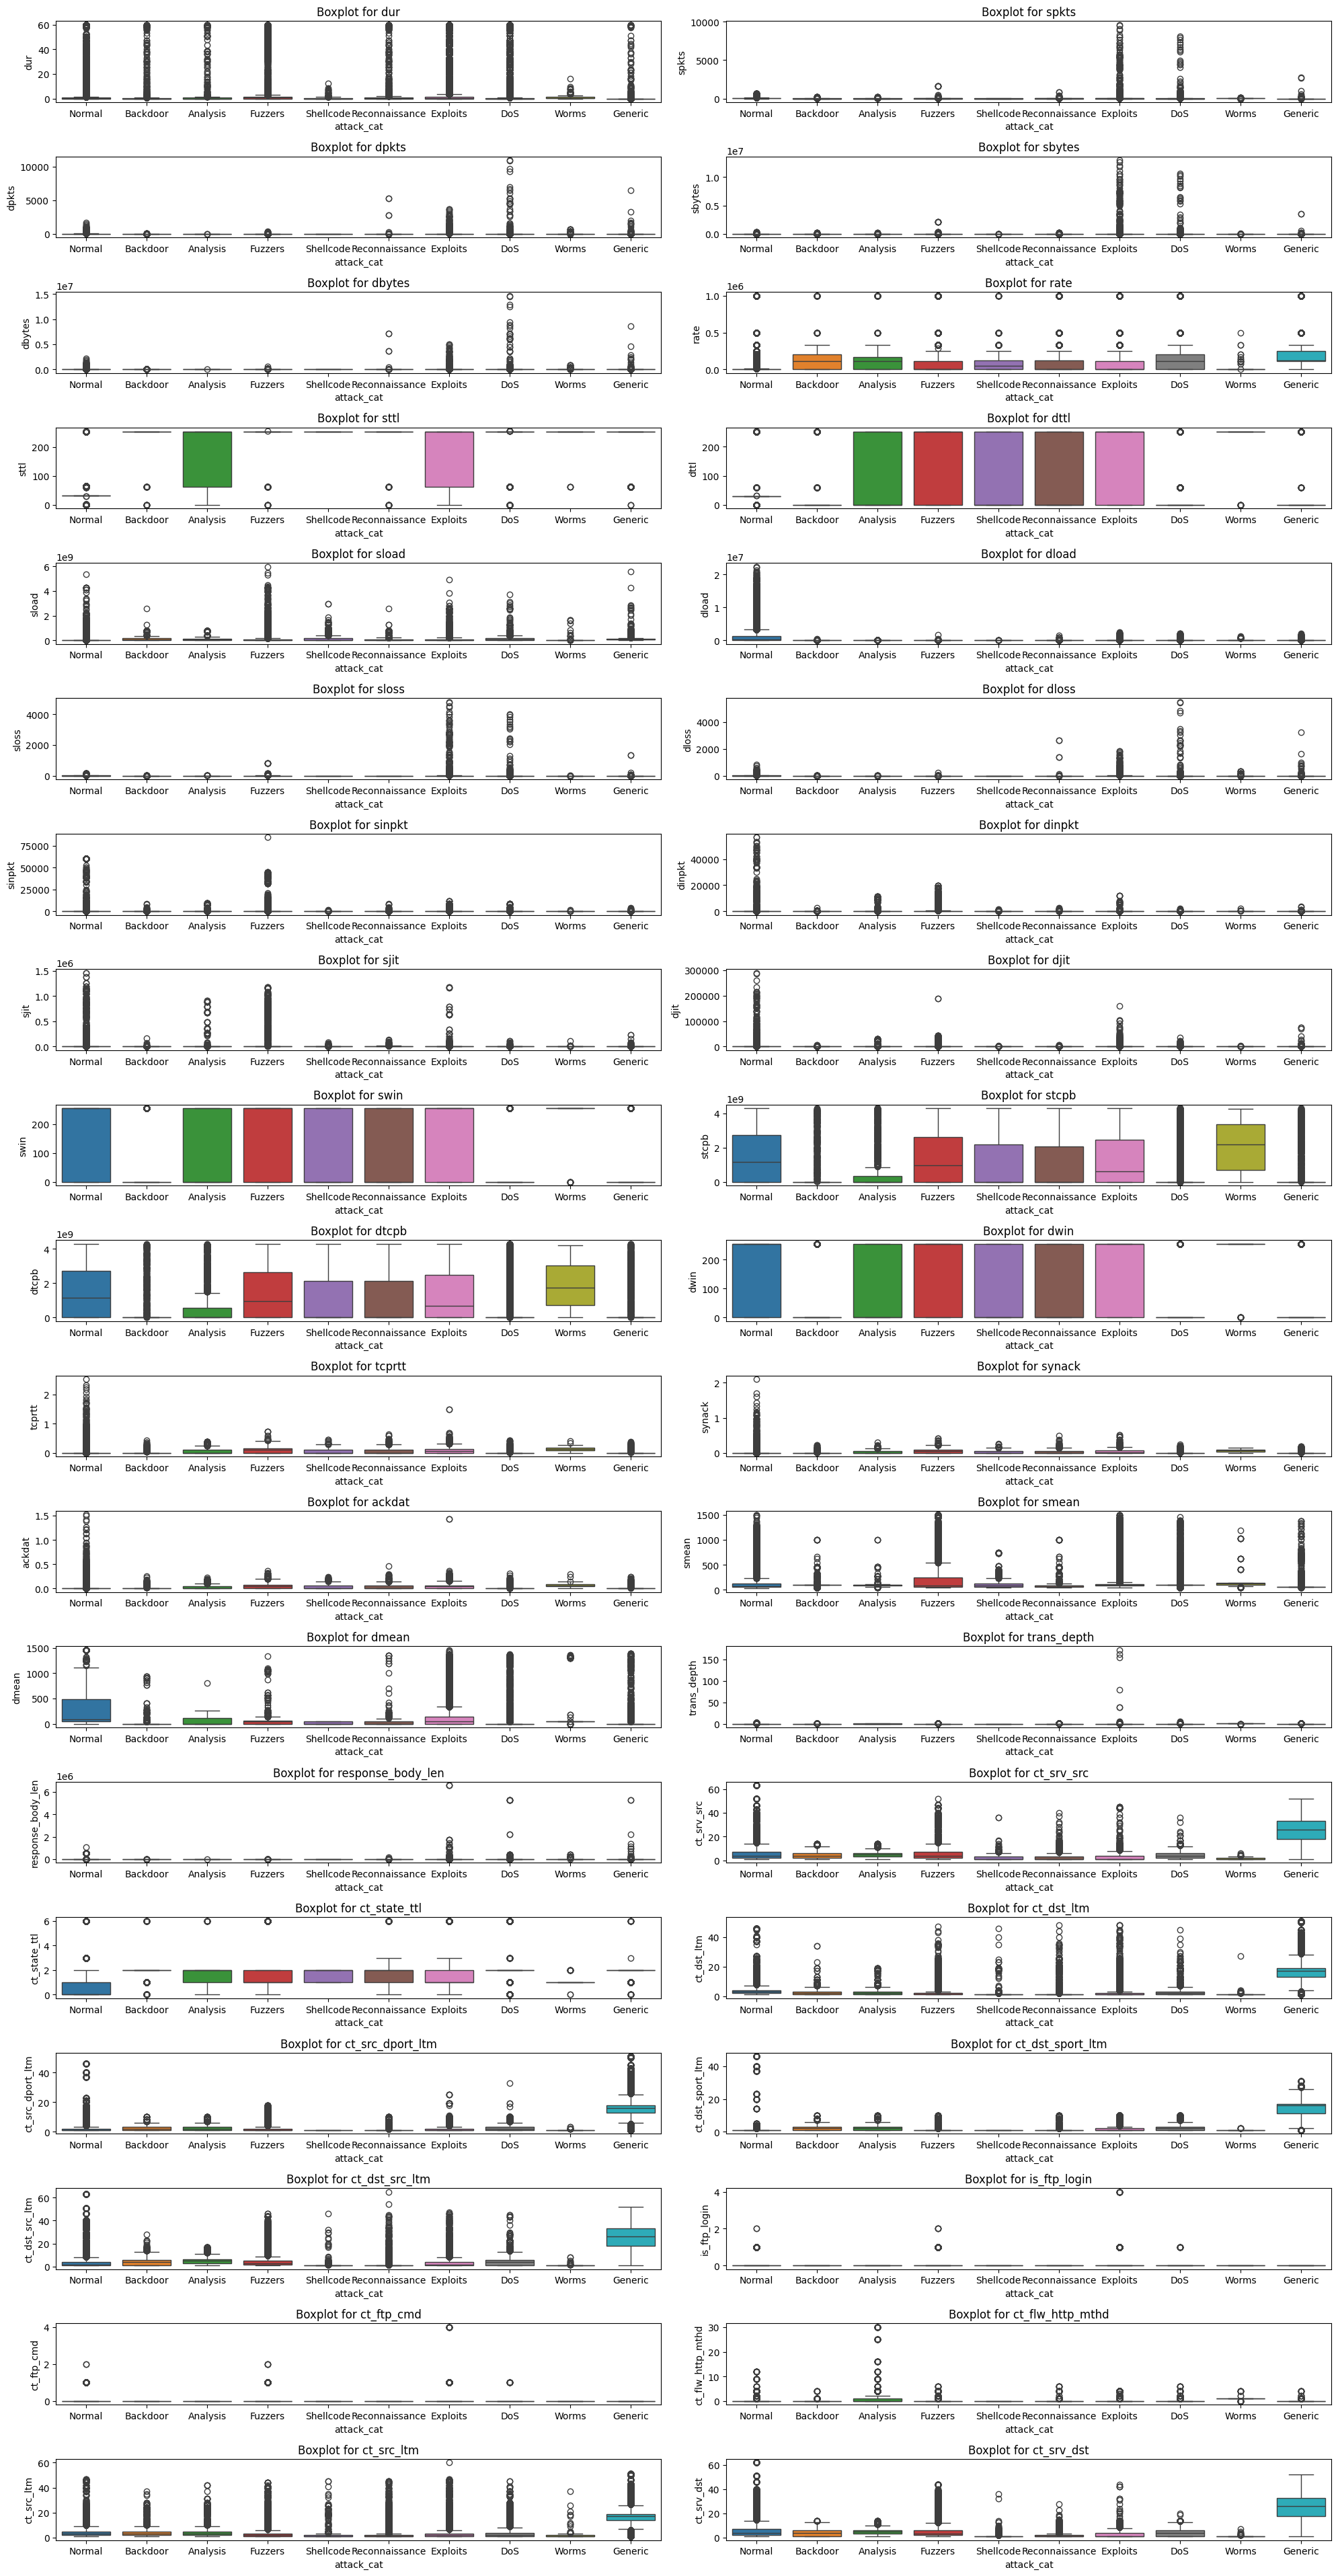

In [13]:
fig, axes = plt.subplots(20,2, figsize=(20,40), tight_layout=True)
axes = axes.flatten()

for col,ax in zip(columns_numeric, axes):
    g = sns.boxplot(data = train_data, y = col, x = train_data["attack_cat"],hue = train_data["attack_cat"], ax = ax)
    g.set_title(f"Boxplot for {col}")
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]

plt.show()
    

In [14]:
#class specific

def treat_outliers(dataframe, columns_numeric, isTest=False):
    """
    Treats outliers in the dataset for the specified numeric columns.

    On the training set:
        - Identifies outliers using the IQR method for each column grouped by "attack_cat".
        - Replaces outliers with the mean value of the column grouped by "attack_cat".
        - Stores the IQR bounds for each column and class.

    On the test set:
        - Uses the stored IQR bounds from training for each column and class.
        - Replaces outliers with the mean value of the column grouped by "attack_cat".

    Parameters:
        dataframe (pd.DataFrame): The dataset to process.
        columns_numeric (list): List of numeric columns to focus on for outlier treatment.
        isTest (bool): Whether the function is applied to the test set.

    Returns:
        pd.DataFrame: The processed dataset with outliers treated.
    """
    if not hasattr(treat_outliers, "iqr_bounds"):
        treat_outliers.iqr_bounds = {}  # Store IQR bounds for training (keyed by column and class)

    if isTest and not treat_outliers.iqr_bounds:
        raise ValueError("IQR bounds are not set. Train the function on the training data first.")

    print("Treating outliers...")
    
    # Ensure all numeric columns are cast to float to handle outliers consistently
    dataframe[columns_numeric] = dataframe[columns_numeric].astype(float)

    # Process each numeric column
    for col in columns_numeric:
        if not isTest:
            # Initialize dictionary for column if not already present
            treat_outliers.iqr_bounds[col] = {}

            # Group by "attack_cat" to calculate class-specific IQR bounds
            for attack_cat, group in dataframe.groupby("attack_cat"):
                q1 = group[col].quantile(0.25)
                q3 = group[col].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                treat_outliers.iqr_bounds[col][attack_cat] = (lower_bound, upper_bound)

                # Identify outliers for this class
                outliers = (group[col] < lower_bound) | (group[col] > upper_bound)

                # Replace outliers with the class mean
                replacement_mean = group[col].mean()
                dataframe.loc[group[outliers].index, col] = replacement_mean
        else:
            # Use stored IQR bounds for test set
            for attack_cat, bounds in treat_outliers.iqr_bounds[col].items():
                lower_bound, upper_bound = bounds
        
                # Get test data rows for this attack_cat
                class_rows = dataframe[dataframe["attack_cat"] == attack_cat]
        
                # Identify outliers
                outliers = (class_rows[col] < lower_bound) | (class_rows[col] > upper_bound)
        
                # Replace outliers with the training class mean
                replacement_mean = dataframe[dataframe["attack_cat"] == attack_cat][col].mean()
                dataframe.loc[class_rows[outliers].index, col] = replacement_mean


    print("Outlier treatment completed.")
    return dataframe


In [15]:
train_data = treat_outliers(train_data, columns_numeric)

Treating outliers...
Outlier treatment completed.


In [16]:
test_data = treat_outliers(test_data, columns_numeric,isTest=True)

Treating outliers...
Outlier treatment completed.


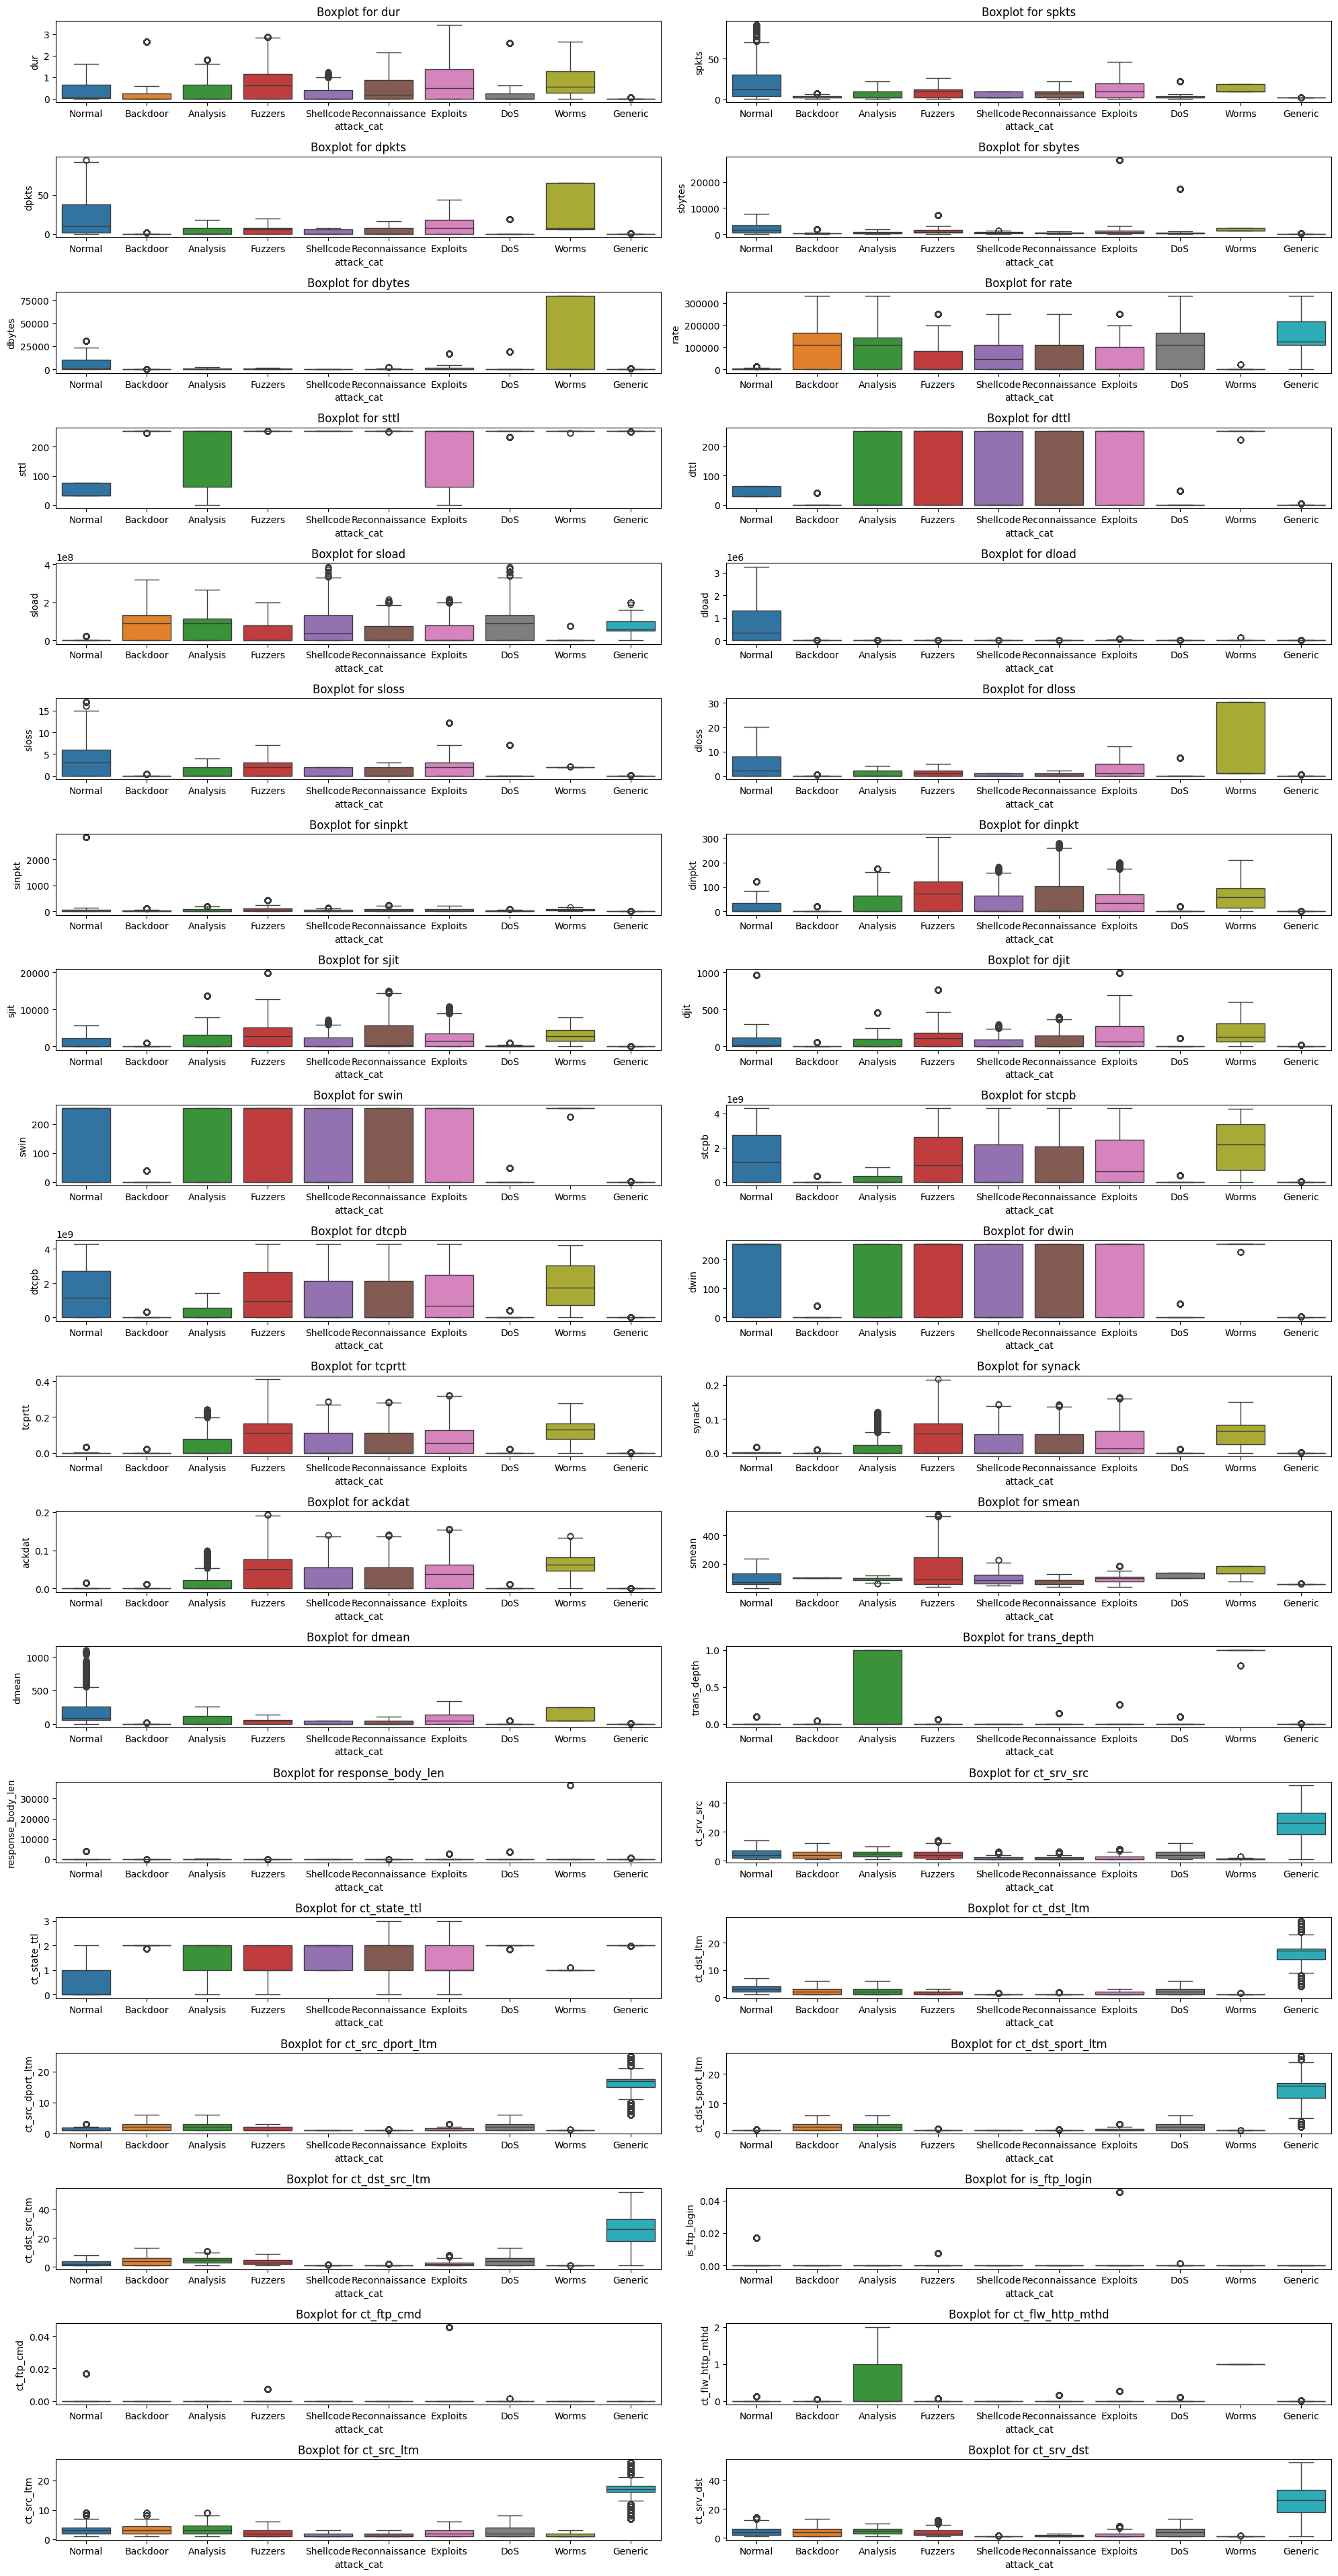

In [17]:
fig, axes = plt.subplots(20,2, figsize=(20,40), tight_layout=True)
axes = axes.flatten()

for col,ax in zip(columns_numeric, axes):
    g = sns.boxplot(data = train_data, y = col, x = train_data["attack_cat"],hue = train_data["attack_cat"], ax = ax)
    g.set_title(f"Boxplot for {col}")
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]

plt.show()

A lot more quantiles are displayed now !!

In [19]:
train_cat = train_data.select_dtypes(exclude=[np.number])
train_cat.describe(include='all')

,proto,service,state,attack_cat
count,175341,175341,175341,175341
unique,133,13,9,10
top,tcp,-,INT,Normal
freq,79946,94168,82275,56000


In [20]:
# Function to reduce categories in categorical columns while preserving the target column
def reduce_categories(train_data, test_data, target_column, threshold=6, debug=False):
    # Select categorical columns in train and test data, excluding the target column
    train_cat = train_data.select_dtypes(exclude=[np.number]).drop(columns=[target_column], errors='ignore')
    test_cat = test_data.select_dtypes(exclude=[np.number]).drop(columns=[target_column], errors='ignore')
    
    # Iterate through categorical columns
    for feature in train_cat.columns:
        if debug:
            print(f"Processing feature: {feature}")
            print(f"Number of unique categories before reduction: {train_cat[feature].nunique()}")
            print('----------------------------------------------------')
        
        # Check if the number of unique categories exceeds the threshold
        if train_cat[feature].nunique() > threshold:
            # Identify the top categories in the train set
            top_categories = train_data[feature].value_counts().head(threshold).index
            
            # Reduce train and test data to these top categories, replacing others with '-'
            train_data[feature] = np.where(train_data[feature].isin(top_categories), train_data[feature], '-')
            test_data[feature] = np.where(test_data[feature].isin(top_categories), test_data[feature], '-')
    
    # Return the modified train and test datasets
    return train_data, test_data

# Apply the function to your train and test datasets
train_data, test_data = reduce_categories(train_data, test_data, target_column='attack_cat', threshold=6, debug=False)

# Check the resulting categorical columns
train_cat = train_data.select_dtypes(exclude=[np.number])
test_cat = test_data.select_dtypes(exclude=[np.number])

print("Train categorical summary after reduction:")
print(train_cat.describe(include='all'))

print("\nTest categorical summary after reduction:")
print(test_cat.describe(include='all'))

Train categorical summary after reduction:
         proto service   state attack_cat
count   175341  175341  175341     175341
unique       7       6       7         10
top        tcp       -     INT     Normal
freq     79946   96842   82275      56000

Test categorical summary after reduction:
        proto service  state attack_cat
count   82332   82332  82332      82332
unique      7       6      6         10
top       tcp       -    FIN     Normal
freq    43095   47879  39339      37000


## Normalizing and Scaling

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [23]:
numeric = train_data.select_dtypes(include="number").columns

normalizer = MinMaxScaler().set_output(transform="pandas")
scaler = StandardScaler().set_output(transform="pandas")
r_scaler = RobustScaler().set_output(transform="pandas")

train_data[numeric] = r_scaler.fit_transform(train_data[numeric])
test_data[numeric] = r_scaler.transform(test_data[numeric])

train_data[numeric] = scaler.fit_transform(train_data[numeric])
test_data[numeric] = scaler.transform(test_data[numeric])

train_data[numeric] = normalizer.fit_transform(train_data[numeric])
test_data[numeric] = normalizer.transform(test_data[numeric])

In [24]:
train_data.shape, test_data.shape

((175341, 44), (82332, 44))

In [25]:
len(train_data["state"].unique()), len(test_data["state"].unique())

(7, 6)

## Treating Skewness

In [27]:
import pandas as pd
import numpy as np

# Set skewness threshold (e.g., |skewness| > 1 is considered highly skewed)
skew_threshold = 1

numeric_cols = train_data.select_dtypes(include = "number").columns

# Select numeric columns
# Calculate skewness for numeric columns
skewness = train_data[numeric_cols].skew()

# Identify columns with skewness above the threshold
skewed_cols = skewness[skewness.abs() > skew_threshold].index
print("Skewed columns:", skewed_cols)

# Apply log transformation to skewed columns
for col in skewed_cols:
    # Add 1 to avoid issues with log(0)
    train_data[col] = np.log1p(train_data[col])
    test_data[col] = np.log1p(test_data[col])  # Apply same transformation to test data


Skewed columns: Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'dttl', 'sload',
       'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'stcpb',
       'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_dst_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')


# Feature Engineering

## OneHotEncoding

In [30]:
# Separate features and labels
train_data_X = train_data.drop(columns=["attack_cat", "label"])
train_data_y = train_data[["attack_cat", "label"]]

test_data_X = test_data.drop(columns=["attack_cat", "label"])
test_data_y = test_data[["attack_cat", "label"]]

# Identify categorical columns
categorical_cols = train_data_X.select_dtypes(include="object").columns
print(categorical_cols)  # Verify the categorical columns

# Use OneHotEncoder with handle_unknown='ignore' to ensure consistency
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define and fit the encoder on training data
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')  # Drop first category to avoid dummy variable trap
ct = ColumnTransformer(transformers=[('encoder', encoder, categorical_cols)], remainder='passthrough')

# Fit the encoder on train data
train_data_X_encoded = ct.fit_transform(train_data_X)

# Transform the test data using the same encoder
test_data_X_encoded = ct.transform(test_data_X)

# Convert the encoded data back to DataFrame for alignment
import pandas as pd
train_data_X_encoded = pd.DataFrame(train_data_X_encoded, columns=ct.get_feature_names_out(), index=train_data_X.index)
test_data_X_encoded = pd.DataFrame(test_data_X_encoded, columns=ct.get_feature_names_out(), index=test_data_X.index)

# Ensure consistent columns between train and test
train_data_X, test_data_X = train_data_X_encoded.align(test_data_X_encoded, join="outer", axis=1, fill_value=0)

Index(['proto', 'service', 'state'], dtype='object')


In [31]:
for index, column_name in enumerate(test_data_X.columns):
    print(index, column_name)

0 encoder__proto_arp
1 encoder__proto_ospf
2 encoder__proto_sctp
3 encoder__proto_tcp
4 encoder__proto_udp
5 encoder__proto_unas
6 encoder__service_dns
7 encoder__service_ftp
8 encoder__service_ftp-data
9 encoder__service_http
10 encoder__service_smtp
11 encoder__state_CON
12 encoder__state_ECO
13 encoder__state_FIN
14 encoder__state_INT
15 encoder__state_REQ
16 encoder__state_RST
17 remainder__dur
18 remainder__spkts
19 remainder__dpkts
20 remainder__sbytes
21 remainder__dbytes
22 remainder__rate
23 remainder__sttl
24 remainder__dttl
25 remainder__sload
26 remainder__dload
27 remainder__sloss
28 remainder__dloss
29 remainder__sinpkt
30 remainder__dinpkt
31 remainder__sjit
32 remainder__djit
33 remainder__swin
34 remainder__stcpb
35 remainder__dtcpb
36 remainder__dwin
37 remainder__tcprtt
38 remainder__synack
39 remainder__ackdat
40 remainder__smean
41 remainder__dmean
42 remainder__trans_depth
43 remainder__response_body_len
44 remainder__ct_srv_src
45 remainder__ct_state_ttl
46 remai

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Ensure you work with copies of the DataFrames
train_data_X = train_data_X.copy()
test_data_X = test_data_X.copy()

# Filter only numeric columns for scaling
numeric_cols_train = train_data_X.select_dtypes(include=['number']).columns
numeric_cols_test = test_data_X.select_dtypes(include=['number']).columns

# Ensure numeric columns are cast to float before scaling
train_data_X[numeric_cols_train] = train_data_X[numeric_cols_train].astype(float)
test_data_X[numeric_cols_test] = test_data_X[numeric_cols_test].astype(float)

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply StandardScaler to train_data
train_data_scaled = standard_scaler.fit_transform(train_data_X[numeric_cols_train])
train_data_X.loc[:, numeric_cols_train] = train_data_scaled

# Apply StandardScaler to test_data
test_data_scaled = standard_scaler.transform(test_data_X[numeric_cols_test])
test_data_X.loc[:, numeric_cols_test] = test_data_scaled

# Apply MinMaxScaler to train_data
train_data_scaled = minmax_scaler.fit_transform(train_data_X[numeric_cols_train])
train_data_X.loc[:, numeric_cols_train] = train_data_scaled

# Apply MinMaxScaler to test_data
test_data_scaled = minmax_scaler.transform(test_data_X[numeric_cols_test])
test_data_X.loc[:, numeric_cols_test] = test_data_scaled


### Converting data to required format

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data_X = pd.DataFrame(scaler.fit_transform(train_data_X), columns=train_data_X.columns)
test_data_X = pd.DataFrame(scaler.transform(test_data_X), columns=test_data_X.columns)

In [35]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = pd.DataFrame(label_encoder.fit_transform(train_data_y["attack_cat"]))
test_labels_encoded = pd.DataFrame(label_encoder.transform(test_data_y["attack_cat"]))

In [36]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import EditedNearestNeighbours
#ENN reduces the majority class by keeping only well separated instances
enn = EditedNearestNeighbours(sampling_strategy = "all", n_neighbors = 3)
#train_data_X, train_data_y = enn.fit_resample(train_data_X, train_labels_encoded)

In [37]:
from imblearn.combine import SMOTEENN

# Combine SMOTE (oversampling) and ENN (cleaning majority class)
smote_enn = SMOTEENN(sampling_strategy="auto", enn = enn, random_state=42)

# Apply SMOTEENN
train_data_X, train_data_y = smote_enn.fit_resample(train_data_X, train_labels_encoded)

# Check the class distribution after resampling
from collections import Counter
print(f"Class distribution after resampling: {Counter(train_data_y)}")

Class distribution after resampling: Counter({0: 1})


In [38]:
#train_data_X = pd.concat([train_data_X, pca_df], axis=1)
#test_data_X = pd.concat([test_data_X, pca_df_test], axis=1)

In [39]:
train_data_y.value_counts()

0
6    56000
9    56000
5    55997
8    55788
7    55312
4    53937
3    45611
1    35039
0    34769
2    33001
Name: count, dtype: int64

## Feature Selection

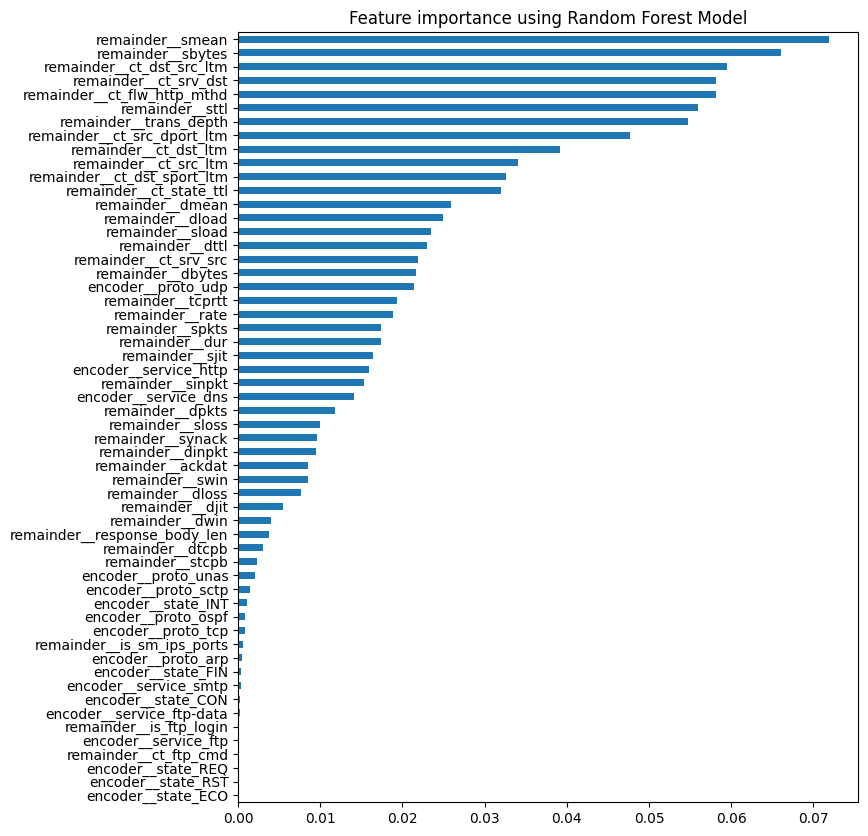

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=15)
numeric_cols = train_data_X.select_dtypes(include = "number")
rf_classifier.fit(numeric_cols, train_data_y.values.ravel())

feature_importances = pd.Series(rf_classifier.feature_importances_, index=numeric_cols.columns)

def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

plot_importance(feature_importances, 'Random Forest')

In [42]:
feature_importances

encoder__proto_arp              0.000469
encoder__proto_ospf             0.000881
encoder__proto_sctp             0.001504
encoder__proto_tcp              0.000814
encoder__proto_udp              0.021442
encoder__proto_unas             0.002004
encoder__service_dns            0.014099
encoder__service_ftp            0.000117
encoder__service_ftp-data       0.000206
encoder__service_http           0.015968
encoder__service_smtp           0.000300
encoder__state_CON              0.000254
encoder__state_ECO              0.000001
encoder__state_FIN              0.000393
encoder__state_INT              0.001063
encoder__state_REQ              0.000088
encoder__state_RST              0.000003
remainder__dur                  0.017382
remainder__spkts                0.017384
remainder__dpkts                0.011769
remainder__sbytes               0.066007
remainder__dbytes               0.021649
remainder__rate                 0.018820
remainder__sttl                 0.055984
remainder__dttl 

In [43]:
top_40_features = [
    "sttl",
    "PC1",
    "dttl",
    "ct_dst_src_ltm",
    "ct_dst_ltm",
    "ct_dst_sport_ltm",
    "ct_state_ttl",
    "ct_src_dport_ltm",
    "ct_src_ltm",
    "ct_srv_dst",
    "ct_srv_src",
    "ackdat",
    "tcprtt",
    "sbytes",
    "smean",
    "dload",
    "rate",
    "dmean",
    "dur",
    "PC3",
    "PC10",
    "dbytes",
    "synack",
    "PC2",
    "ct_flw_http_mthd",
    "trans_depth",
    "PC4",
    "sload",
    "PC5",
    "sinpkt",
    "PC8",
    "spkts",
    "dpkts",
    "PC9",
    "sloss",
    "sjit",
    "PC7",
    "dloss",
    "dwin",
    "swin"
]

In [44]:
from sklearn.feature_selection import f_classif #computes ANOVA 
from sklearn.feature_selection import SelectKBest  #Orders f statistics and selects the Kbest ones

def anova_test():

    
    X_vars = train_data_X[train_data_X.select_dtypes(include='number').columns]
    
    y_var = train_data_y
    
    anova = SelectKBest(f_classif, k=40) #we choose to keep the 10 best ones, try different numbers
    
    
    X_anova = anova.fit_transform(X_vars, y_var)
    
    anova_results = pd.DataFrame({'Feature': X_vars.columns, 
                                  'F-value': anova.scores_,
                                  'p-value': anova.pvalues_})
    
    anova_results.sort_values(by='F-value', ascending=False, inplace=True)

    
    selected_features = pd.Series(anova.get_support(), index = X_vars.columns)
    features_to_use = [feature for feature, keep in selected_features.items() if keep]

    features_to_use_str = '", "'.join(features_to_use)
    
    return selected_features, anova_results, features_to_use_str

In [45]:
anova_test()

C:\Users\TESTER\anaconda3\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(encoder__proto_arp              False
 encoder__proto_ospf             False
 encoder__proto_sctp             False
 encoder__proto_tcp               True
 encoder__proto_udp               True
 encoder__proto_unas             False
 encoder__service_dns             True
 encoder__service_ftp            False
 encoder__service_ftp-data       False
 encoder__service_http            True
 encoder__service_smtp           False
 encoder__state_CON              False
 encoder__state_ECO              False
 encoder__state_FIN               True
 encoder__state_INT               True
 encoder__state_REQ              False
 encoder__state_RST              False
 remainder__dur                   True
 remainder__spkts                 True
 remainder__dpkts                 True
 remainder__sbytes                True
 remainder__dbytes                True
 remainder__rate                  True
 remainder__sttl                  True
 remainder__dttl                  True
 remainder__sload        

In [46]:
features = ["encoder__proto_tcp", "encoder__proto_udp", "encoder__service_dns", "encoder__service_http", "encoder__state_FIN", "encoder__state_INT", "remainder__dur", "remainder__spkts", "remainder__dpkts", "remainder__sbytes", "remainder__dbytes", "remainder__rate", "remainder__sttl", "remainder__dttl", "remainder__sload", "remainder__dload", "remainder__sloss", "remainder__dloss", "remainder__dinpkt", "remainder__sjit", "remainder__djit", "remainder__swin", "remainder__stcpb", "remainder__dtcpb", "remainder__dwin", "remainder__tcprtt", "remainder__synack", "remainder__ackdat", "remainder__smean", "remainder__dmean", "remainder__trans_depth", "remainder__ct_srv_src", "remainder__ct_state_ttl", "remainder__ct_dst_ltm", "remainder__ct_src_dport_ltm", "remainder__ct_dst_sport_ltm", "remainder__ct_dst_src_ltm", "remainder__ct_flw_http_mthd", "remainder__ct_src_ltm", "remainder__ct_srv_dst"]

# Modelling

## Modelling DNN/MLP

In [49]:
#train_X_tensor = torch.tensor(train_data_X[features].values, dtype=torch.float32).squeeze()
#test_X_tensor = torch.tensor(test_data_X[features].values, dtype=torch.float32).squeeze() #changed to have all features

train_X_tensor = torch.tensor(train_data_X[features].values, dtype=torch.float32).squeeze()
test_X_tensor = torch.tensor(test_data_X[features].values, dtype=torch.float32).squeeze()

train_Y_tensor = torch.tensor(train_data_y.values, dtype=torch.long).squeeze()
test_Y_tensor = torch.tensor(test_labels_encoded.values, dtype=torch.long).squeeze()

dataset = {'train_input': train_X_tensor,
    'train_label': train_Y_tensor,
    'test_input': test_X_tensor,
    'test_label': test_Y_tensor} #a dictionary with the 4 datasets

In [50]:
dataset["train_input"].shape

torch.Size([481454, 40])

In [51]:
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [52]:

# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)


In [53]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [116]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_shape: int, hidden_units1: int, hidden_units2: int, hidden_units3: int, hidden_units4: int, output_shape: int):
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
        )

        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(in_features=hidden_units2, out_features=hidden_units2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
        )

        # **New Block Added Here**
        self.linear_relu_stack3 = nn.Sequential(
            nn.Linear(in_features=hidden_units3, out_features=hidden_units3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units4),
        )

        self.linear_relu_stack4 = nn.Sequential(
            nn.Linear(in_features=hidden_units4, out_features=hidden_units4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units4, out_features=hidden_units4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units4, out_features=output_shape),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.linear_relu_stack2(x)
        x = self.linear_relu_stack3(x)  # Pass through new block
        logits = self.linear_relu_stack4(x)  # Final output layer

        return logits



In [55]:
learning_rate = 1e-3
batch_size = 32
epochs = 100

Training and test loops

In [57]:
from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0  # For accuracy tracking
    total = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    accuracy = correct / total * 100
    print(f"Train Accuracy: {accuracy:.4f}%")

def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Collect all predictions and true labels for F1-score calculation
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100  # Weighted F1-score to handle class imbalance

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, F1-score: {f1:.2f}% \n")


In [118]:
model = NeuralNetwork(40,128,64,32,10,10)

In [120]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, scheduler)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.307599  [    0/481454]
loss: 2.291496  [ 3200/481454]
loss: 2.286385  [ 6400/481454]
loss: 2.326994  [ 9600/481454]
loss: 2.349142  [12800/481454]
loss: 2.291615  [16000/481454]
loss: 2.338634  [19200/481454]
loss: 2.179152  [22400/481454]
loss: 2.201157  [25600/481454]
loss: 2.301143  [28800/481454]
loss: 1.990719  [32000/481454]
loss: 1.870770  [35200/481454]
loss: 2.083611  [38400/481454]
loss: 1.922900  [41600/481454]
loss: 1.676264  [44800/481454]
loss: 1.772164  [48000/481454]
loss: 1.624951  [51200/481454]
loss: 2.009366  [54400/481454]
loss: 1.824175  [57600/481454]
loss: 1.690348  [60800/481454]
loss: 1.559734  [64000/481454]
loss: 1.671610  [67200/481454]


KeyboardInterrupt: 

In [60]:
def plot_loss_landscape(model, loss_fn, dataloader, num_points=10, alpha=1.0, max_batches=5):
    # Store original parameters
    original_params = [p.clone() for p in model.parameters()]
    
    # Calculate two random directions
    direction1 = [torch.randn_like(p) for p in model.parameters()]
    direction2 = [torch.randn_like(p) for p in model.parameters()]
    
    # Normalize directions
    norm1 = torch.sqrt(sum(torch.sum(d**2) for d in direction1))
    norm2 = torch.sqrt(sum(torch.sum(d**2) for d in direction2))
    direction1 = [d / norm1 for d in direction1]
    direction2 = [d / norm2 for d in direction2]
    
    # Create grid
    x = np.linspace(-alpha, alpha, num_points)
    y = np.linspace(-alpha, alpha, num_points)
    X, Y = np.meshgrid(x, y)
    
    # Calculate loss for each point
    Z = np.zeros_like(X)
    for i in range(num_points):
        for j in range(num_points):
            # Update model parameters
            for p, d1, d2 in zip(model.parameters(), direction1, direction2):
                p.data = p.data + X[i, j] * d1 + Y[i, j] * d2
            
            # Calculate loss on a subset of batches
            total_loss = 0
            num_batches = 0
            for batch_idx, batch in enumerate(dataloader):
                if batch_idx >= max_batches:  # Limit number of batches
                    break
                inputs, targets = batch
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                total_loss += loss.item()
                num_batches += 1
            Z[i, j] = total_loss / num_batches
            
            # Reset model parameters
            for p, orig_p in zip(model.parameters(), original_params):
                p.data = orig_p.clone()
    
    # Plot the loss landscape
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Direction 1')
    ax.set_ylabel('Direction 2')
    ax.set_zlabel('Loss')
    ax.set_title('Loss Landscape')
    fig.colorbar(surf)
    
    return fig


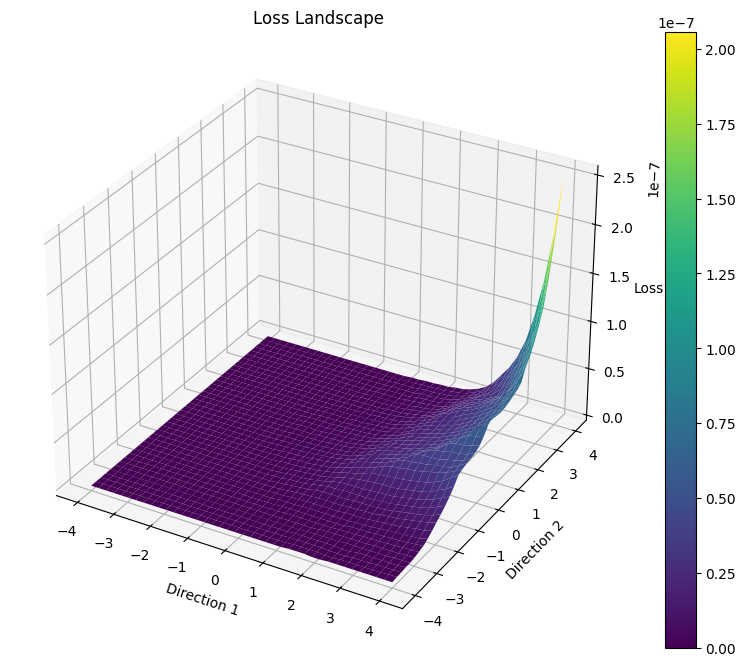

In [61]:
fig = plot_loss_landscape(
    model=model,
    loss_fn=loss_fn,
    dataloader=test_dataloader,
    num_points=40,      # Adjust the resolution of the plot (lower for faster computation)
    alpha=4.0,          # Scale of the perturbations in parameter space
    max_batches=5       # Limit the number of batches for faster execution
)

# Show the plot
plt.show()